<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/2.%20%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%965_%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B9_%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%BE%D0%B2_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №5. Создание простой рекомендательной системы на основе алгоритмов кластеризации

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [7]:
colab = False  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [8]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('./archive/anime.csv', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [9]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('./archive/rating.csv')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет.

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут.

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее.

### 1. Избавьтесь от -1

In [10]:
# Получение уникальных значений в столбце "rating"
unique_ratings = ratings['rating'].unique()
unique_rating_anime  = anime['rating'].unique()

unique_ratings_str = ", ".join(map(str, unique_ratings)) #нуля не нашёл в датасете
print("Уникальные значения в столбце 'rating(ratings)':", unique_ratings_str)


unique_ratings_str = ", ".join(map(str, unique_rating_anime))
print("Уникальные значения в столбце 'rating'(anime):", unique_rating_anime)


Уникальные значения в столбце 'rating(ratings)': -1, 10, 8, 6, 9, 7, 3, 5, 4, 1, 2
Уникальные значения в столбце 'rating'(anime): [ 9.37  9.26  9.25  9.17  9.16  9.15  9.13  9.11  9.1   9.06  9.05  9.04
  8.98  8.93  8.92  8.88  8.84  8.83  8.82  8.81  8.8   8.78  8.77  8.76
  8.75  8.74  8.73  8.72  8.71  8.69  8.68  8.67  8.66  8.65  8.64  8.62
  8.61  8.6   8.59  8.58  8.57  8.56  8.55  8.54  8.53  8.52  8.51  8.5
  8.49  8.48  8.47  8.46  8.45  8.44  8.43  8.42  8.41  8.4   8.39  8.38
  8.37  8.36  8.35  8.34  8.33  8.32  8.31  8.3   8.29  8.28  8.27  8.26
  8.25  8.24  8.23  8.22  8.21  8.2   8.19  8.18  8.17  8.16  8.15  8.14
  8.13  8.12  8.11  8.1   8.09  8.08  8.07  8.06  8.05  8.04  8.03  8.02
  8.01  8.    7.99  7.98  7.97  7.96  7.95  7.94  7.93  7.92  7.91  7.9
  7.89  7.88  7.87  7.86  7.85  7.84  7.83  7.82  7.81  7.8   7.79  7.78
  7.77  7.76  7.75  7.74  7.73  7.72  7.71  7.7   7.69  7.68  7.67  7.66
  7.65  7.64  7.63  7.62  7.61  7.6   7.59  7.58  7.57  7.56  7.55  7

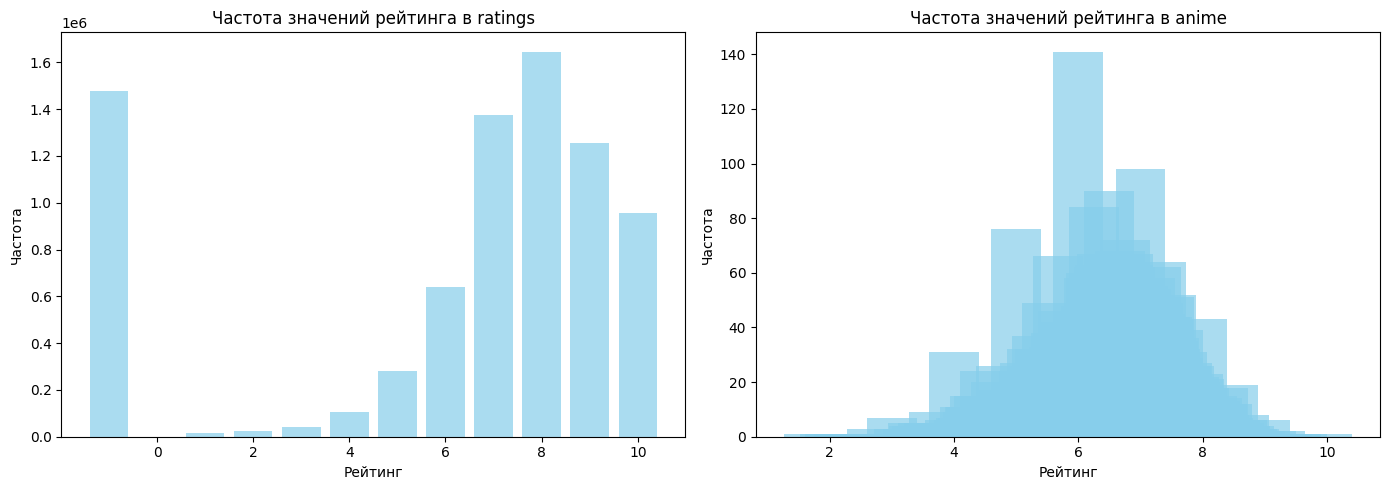

In [11]:
# Вычисление частоты значений рейтинга для ratings
rating_counts_ratings = ratings['rating'].value_counts()

# Вычисление частоты значений рейтинга для anime
rating_counts_anime = anime['rating'].value_counts()

# Создание субплотов для размещения гистограмм рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма для ratings
axes[0].bar(rating_counts_ratings.index, rating_counts_ratings.values, color='skyblue', alpha=0.7)
axes[0].set_xlabel('Рейтинг')
axes[0].set_ylabel('Частота')
axes[0].set_title('Частота значений рейтинга в ratings')

# Гистограмма для anime
axes[1].bar(rating_counts_anime.index, rating_counts_anime.values, color='skyblue', alpha=0.7)
axes[1].set_xlabel('Рейтинг')
axes[1].set_ylabel('Частота')
axes[1].set_title('Частота значений рейтинга в anime')

plt.tight_layout()
plt.show()

In [12]:
# Удаление строк, где значение "rating" равно -1
ratings = ratings[ratings['rating'] != -1]
unique_ratings = ratings['rating'].unique()
unique_ratings_str = ", ".join(map(str, unique_ratings)) #нуля не нашёл в датасете
print("Уникальные значения в столбце 'rating(ratings)':", unique_ratings_str)

Уникальные значения в столбце 'rating(ratings)': 10, 8, 6, 9, 7, 3, 5, 4, 1, 2


## Критерий Шавене (Chauvenet)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn.

In [8]:
from scipy.special import erfc
import numpy as np

def chauvenet(array, epsilon=1e-6, k = 2):
    mean = array.mean()           # Среднее значение массива
    stdv = array.std(ddof=1)          # Стандартное отклонение
    N = len(array)                # Длина массива
    d = abs(array - mean) / (stdv)  # Расстояние значения до среднего в стандартных отклонениях
    d /= 2.0**0.5  
  #  print('mean: ',mean)
   # print('std: ',stdv)
    criterion = 1.0 / (k  * N)  # Критерий Шавене
    prob = erfc(d) # Площадь под нормальным распределением
    
    # Проверка на выбросы
 #   print(prob)
   # print('criterion: ', criterion)
    outliers = prob < criterion

    return outliers

def remove_outliers(data, outliers):
    # Удаляем элементы массива данных, соответствующие выбросам
    cleaned_data = data[~outliers]
   #print(f"Удалено {len(removed_data)} значений: {removed_data}")

    return cleaned_data



In [9]:
    # Пример данных
data = np.array([8.02, 8.16, 3.97, 8.64, 0.84, 4.46, 0.81, 7.74, 8.78, 9.26, 20.46, 29.87, 10.38, 25.71])
outliers = np.ones(len(data), dtype=bool)  # Инициализируем outliers, чтобы войти в цикл

iteration = 1
while outliers.any():  # Пока есть выбросы
        data.sort()
        print('Итерация ', iteration)
        iteration += 1
        print('Массив: ',data)
        # Вызываем функцию chauvenet для определения выбросов
        
        outliers = chauvenet(data)
        # Удаляем выбросы из данных
        data = remove_outliers(data, outliers)

    # Выводим результаты
print("Очищенные данные:", data)

Итерация  1
Массив:  [ 0.81  0.84  3.97  4.46  7.74  8.02  8.16  8.64  8.78  9.26 10.38 20.46
 25.71 29.87]
[0.26871038 0.27019416 0.45590073 0.49036691 0.7522948  0.77665663
 0.78892212 0.83135607 0.84383179 0.88688515 0.98842975 0.25629004
 0.0829166  0.02721014]
Удалено 1 значений: [29.87]
Итерация  2
Массив:  [ 0.81  0.84  3.97  4.46  7.74  8.02  8.16  8.64  8.78  9.26 10.38 20.46
 25.71]
[0.24398191 0.24570979 0.47366669 0.51765149 0.85607722 0.88737732
 0.90309667 0.95724281 0.97308392 0.97256148 0.84666045 0.10432266
 0.0178125 ]
Удалено 1 значений: [25.71]
Итерация  3
Массив:  [ 0.81  0.84  3.97  4.46  7.74  8.02  8.16  8.64  8.78  9.26 10.38 20.46]
[0.18707902 0.18902683 0.47913396 0.53996654 0.98250055 0.93932036
 0.91778906 0.8445191  0.823371   0.75192009 0.59412443 0.01300215]
Удалено 1 значений: [20.46]
Итерация  4
Массив:  [ 0.81  0.84  3.97  4.46  7.74  8.02  8.16  8.64  8.78  9.26 10.38]
[0.09426614 0.09602735 0.46085399 0.55363473 0.70462376 0.64407311
 0.61463104 0.5

# Некоторые наблюдения относительно np.std

In [11]:
data = np.array([8.02, 8.16, 3.97, 8.64, 0.84, 4.46, 0.81, 7.74, 8.78, 9.26, 20.46, 29.87, 10.38, 25.71])
std_deviation = np.std(data)

print("Стандартное отклонение:", std_deviation)

Стандартное отклонение: 8.44854038836754


In [12]:
import numpy as np
import math 

data = np.array([8.02, 8.16, 3.97, 8.64, 0.84, 4.46, 0.81, 7.74, 8.78, 9.26, 20.46, 29.87, 10.38, 25.71])
mean = np.mean(data)
variance = math.sqrt(((data - mean) ** 2).sum() / (len(data) - 1))

print("Оценка дисперсии:", variance)

Оценка дисперсии: 8.767464705525615


Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [9]:
count_reviews = ratings[['user_id', 'anime_id']] \
    .groupby(by='user_id') \
    .count() \
    .rename(columns={'anime_id': 'reviews'})
count_reviews

,reviews
user_id,
1,4
2,1
3,92
5,459
7,343
...,...
73512,12
73513,33
73514,1


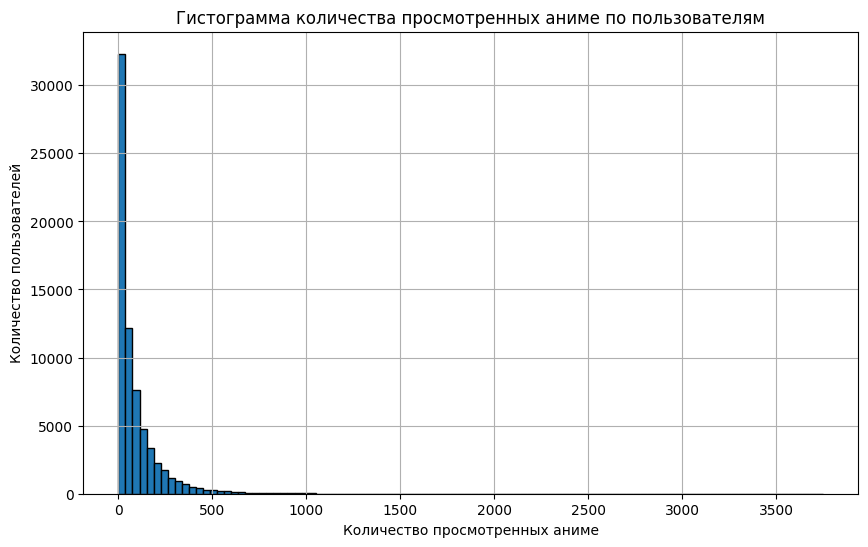

In [12]:
# посмотрев на данные мне стала любопытна одна вещь ...


# Создаем гистограмму
plt.figure(figsize=(10, 6))
plt.hist(count_reviews['reviews'], bins=100, edgecolor='k')
plt.title('Гистограмма количества просмотренных аниме по пользователям')
plt.xlabel('Количество просмотренных аниме')
plt.ylabel('Количество пользователей')
plt.grid(True)

# Отображаем гистограмму
plt.show()

### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [15]:
outlier_users  = count_reviews.values
outliers = np.ones(len(outlier_users), dtype=bool)  # Инициализируем outliers, чтобы войти в цикл

iteration = 1
while outliers.any():  # Пока есть выбросы
        outlier_users.sort()
        
        print('Итерация ', iteration)
        iteration += 1
       # print('Массив: ',outlier_users)
        # Вызываем функцию chauvenet для определения выбросов
        
        outliers = chauvenet(outlier_users)
        # Удаляем выбросы из данных
        outlier_users = remove_outliers(outlier_users, outliers)

    # Выводим результаты
print("Очищенные данные:", outlier_users)

Итерация  1
Итерация  2
Итерация  3
Итерация  4
Итерация  5
Итерация  6
Итерация  7
Итерация  8
Очищенные данные: [  1   1   1 ... 492 492 492]


In [16]:
from dataclasses import dataclass

@dataclass
class OutliersReport:
    iterations: int
    outliers_count: int
    normal_count: int
    min_normal: float
    max_normal: float
    min_outliers: float
    max_outliers: float

    def __str__(self) -> str:
        return ', '.join(f'{field}: {value}' for field, value in self.__dict__.items())

def get_outliers(input: pd.DataFrame):
    """

    """
    outliers = []
    prev_input = input.copy()
    i = 1
    while True:
        input_temp = prev_input.copy()
        input_temp['outliers'] = chauvenet(input_temp.to_numpy()) 
        temp_outliers = input_temp[input_temp.outliers]

        if len(temp_outliers) == 0:
            outliers = pd.concat(outliers)
            result_input = input_temp.drop('outliers', axis=1)
            result_outliers = outliers if outliers.empty else outliers.drop('outliers', axis=1)
            report = OutliersReport(
                i,
                len(outliers),
                len(result_input),
                result_input.min().values[0],
                result_input.max().values[0],
                0 if result_outliers.empty else result_outliers.min().values[0],
                0 if result_outliers.empty else result_outliers.max().values[0]
            )
            return result_input, result_outliers, report
        
        i += 1
        outliers.append(temp_outliers)
        prev_input = input_temp[input_temp.outliers == False].drop('outliers', axis=1)

In [17]:
users, users_outliers, report = get_outliers(count_reviews)
print(report)

iterations: 8, outliers_count: 1411, normal_count: 68189, min_normal: 1, max_normal: 492, min_outliers: 493, max_outliers: 3747


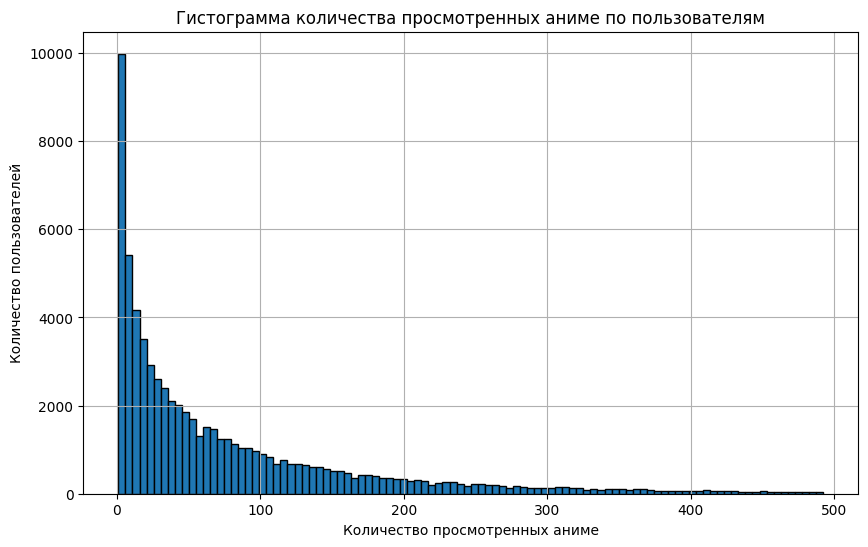

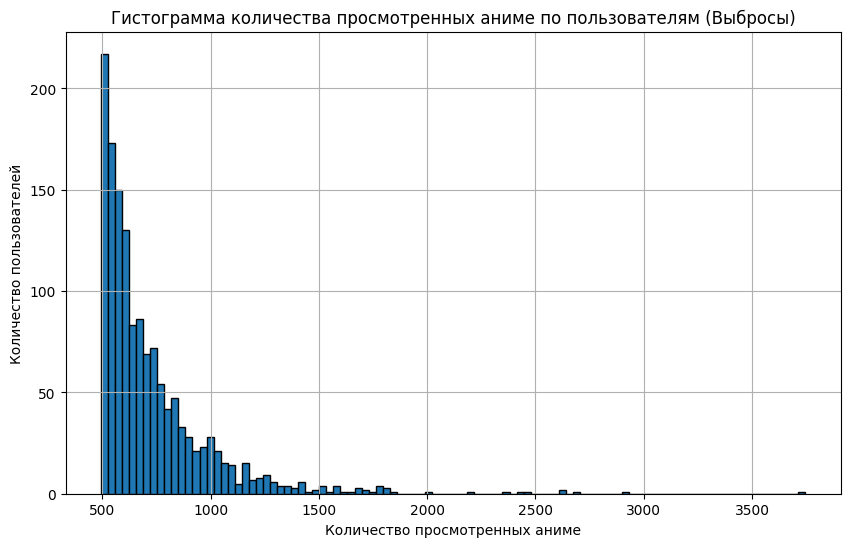

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(users, bins=100, edgecolor='k')
plt.title('Гистограмма количества просмотренных аниме по пользователям')
plt.xlabel('Количество просмотренных аниме')
plt.ylabel('Количество пользователей')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.hist(users_outliers, bins=100, edgecolor='k')
plt.title('Гистограмма количества просмотренных аниме по пользователям (Выбросы)')
plt.xlabel('Количество просмотренных аниме')
plt.ylabel('Количество пользователей')
plt.grid(True)

# Отображаем гистограмму
plt.show()


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом? 

Пользователей с более чем 500 кпросмотренными аниме

#### Почему критерий посчитал их выбросом? 
Потому что большинство пользователей смотрело за свою короткую и быстротечную жизнь от 0 до 100 аниме.

#### Нужна ли им вообще рекомендательная система? 
Тех, кто попал в выброс, можно считать статистически малозначимой группой (~1400 пользователей) против основной категории в 67к. Если же вопрос про рекомендадетльную систему для оставшихся пользователей, то таковая нужна, поскольку количество просмотренного аниме прямопорпоционально заинтересованности пользователя. Таким образом, можно повысить количество часов, проводимых пользователями на сайте


**Ответы:**

`# Ваши ответы #`

In [38]:
bad_user_threshold = users_outliers.min().values[0]
bad_user_threshold

493

Если все было правильно `bad_user_threshold` больше 500.

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [64]:
# Переименуйте столбец в count_reviews
count_reviews.rename(columns={'reviews': 'count_reviews'}, inplace=True)


# Объедините count_reviews и ratings по столбцу user_id
merged_data = pd.merge(count_reviews, ratings, on='user_id')

# Оставьте только тех пользователей, у которых количество обзоров меньше bad_user_threshold
ratings= merged_data[merged_data['count_reviews'] < bad_user_threshold]

# Выведите отфильтрованные данные
print(ratings)

         user_id  count_reviews  anime_id  rating
0              1              4      8074      10
1              1              4     11617      10
2              1              4     11757      10
3              1              4     15451      10
4              2              1     11771      10
...          ...            ...       ...     ...
6337236    73515            179     16512       7
6337237    73515            179     17187       9
6337238    73515            179     22145      10
6337239    73516              2       790       9
6337240    73516              2      8074       9

[5309104 rows x 4 columns]


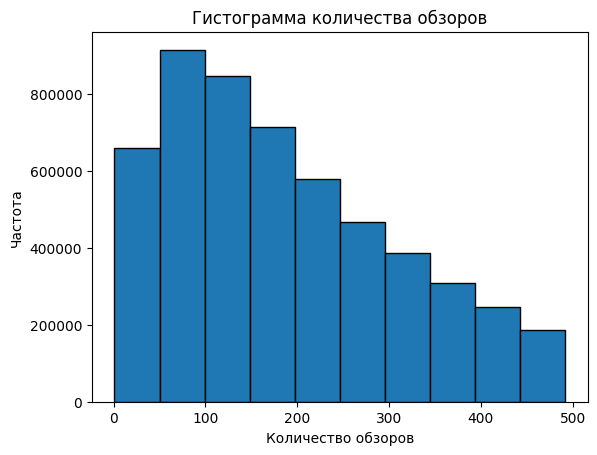

In [65]:
count_reviews_column = ratings['count_reviews']

# Создайте гистограмму
plt.hist(count_reviews_column, bins=10, edgecolor='k')
plt.xlabel('Количество обзоров')
plt.ylabel('Частота')
plt.title('Гистограмма количества обзоров')

# Отобразите гистограмму
plt.show()

Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [66]:
# Рассчитайте медианное значение количества просмотров
median_reviews = ratings['count_reviews'].median()

# Удалите пользователей, у которых количество просмотров меньше медианного значения
ratings = ratings[ratings['count_reviews'] >= median_reviews]

# Выведите отфильтрованный DataFrame
print(ratings)

         user_id  count_reviews  anime_id  rating
97             5            459         6       8
98             5            459        15       6
99             5            459        17       6
100            5            459        18       6
101            5            459        20       6
...          ...            ...       ...     ...
6337234    73515            179     13659       8
6337235    73515            179     14345       7
6337236    73515            179     16512       7
6337237    73515            179     17187       9
6337238    73515            179     22145      10

[2655324 rows x 4 columns]


In [67]:
# Удалим столбец с просмотрами чтобы не мешал.

ratings = ratings.drop(columns=['count_reviews'])

Теперь рассмотрим таблицу `anime`.


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [68]:
anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


In [70]:
anime_rating, anime_rating_outliers, report_anime = get_outliers(pd.DataFrame(anime['rating']))
print(report_anime)

iterations: 2, outliers_count: 4, normal_count: 12013, min_normal: 2.37, max_normal: 10.0, min_outliers: 1.67, max_outliers: 2.14


In [73]:
anime_rating

,rating
anime_id,
32281,9.37
5114,9.26
28977,9.25
9253,9.17
9969,9.16
...,...
9316,4.15
5543,4.28
5621,4.88


In [74]:
anime_rating_outliers

,rating
anime_id,
13405,2.14
3287,2.00
34476,1.67
20007,1.92


In [71]:
anime_members, anime_members_outliers, report_members_anime = get_outliers(pd.DataFrame(anime['members']))
print(report_members_anime)

iterations: 30, outliers_count: 1888, normal_count: 10129, min_normal: 12, max_normal: 23220, min_outliers: 23285, max_outliers: 1013917


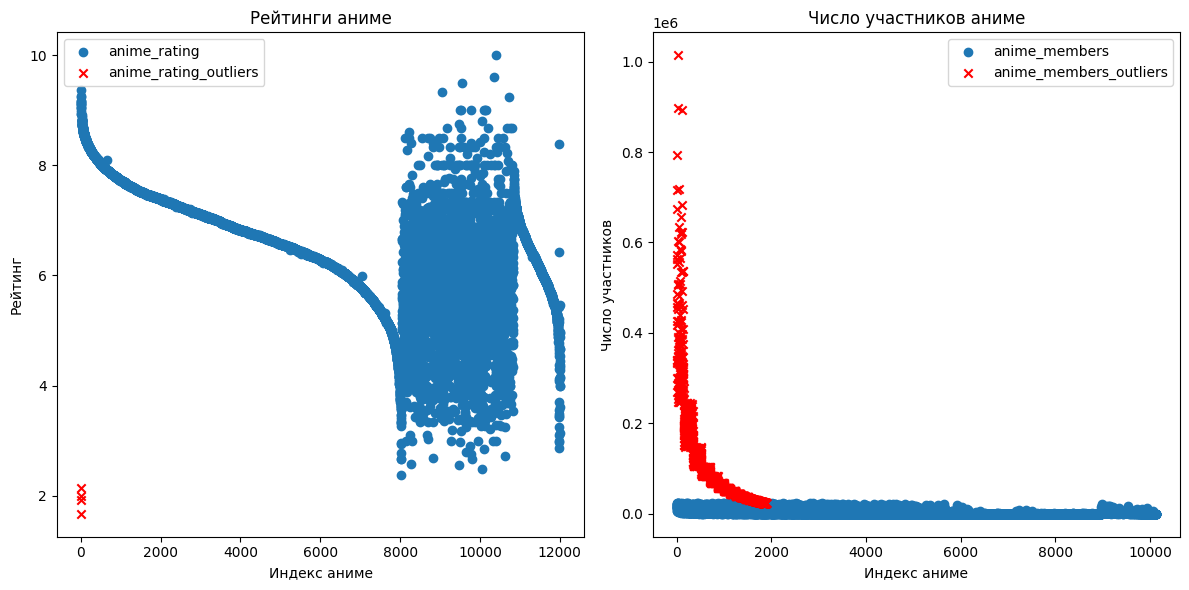

In [83]:
# Создание графика
plt.figure(figsize=(12, 6))

# График для anime_rating
plt.subplot(1, 2, 1)
plt.scatter(range(len(anime_rating)), anime_rating, label='anime_rating', marker='o')
plt.scatter(range(len(anime_rating_outliers)), anime_rating_outliers, label='anime_rating_outliers', marker='x', color='red')
plt.title('Рейтинги аниме')
plt.xlabel('Индекс аниме')
plt.ylabel('Рейтинг')
plt.legend()

# График для anime_members
plt.subplot(1, 2, 2)
plt.scatter(range(len(anime_members)), anime_members, label='anime_members', marker='o')
plt.scatter(range(len(anime_members_outliers)), anime_members_outliers, label='anime_members_outliers', marker='x', color='red')
plt.title('Число участников аниме')
plt.xlabel('Индекс аниме')
plt.ylabel('Число участников')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

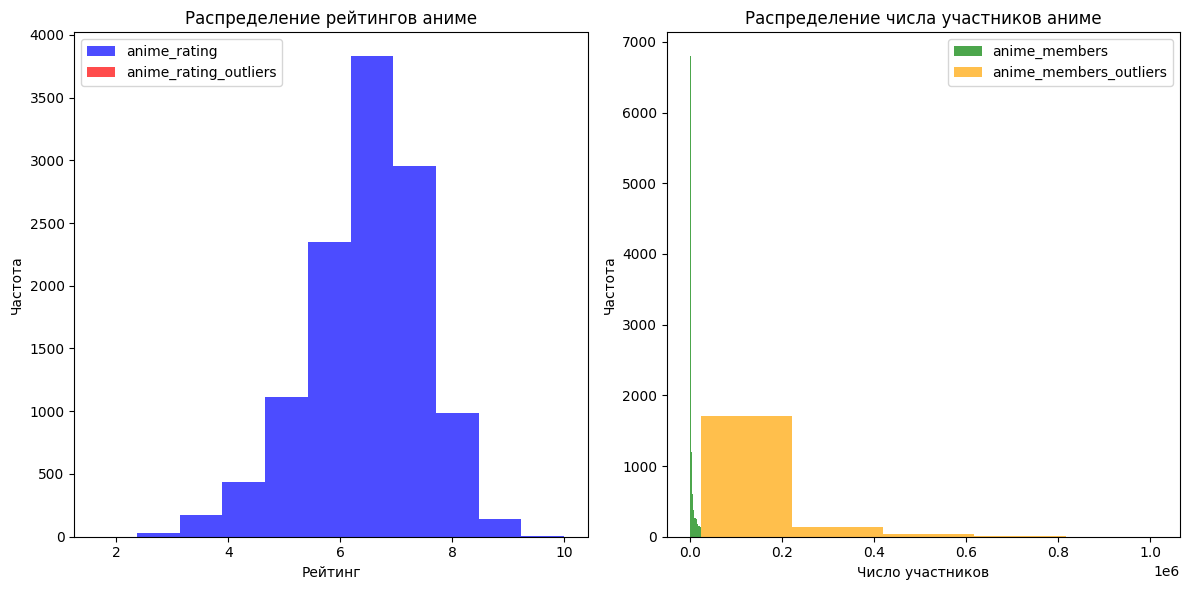

In [82]:
# Создание фигуры с двумя подграфиками (гистограммами)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Построение гистограммы для anime_rating и anime_rating_outliers
ax1.hist(anime_rating, bins=10, color='blue', alpha=0.7, label='anime_rating')
ax1.hist(anime_rating_outliers, bins=5, color='red', alpha=0.7, label='anime_rating_outliers')
ax1.set_xlabel('Рейтинг')
ax1.set_ylabel('Частота')
ax1.set_title('Распределение рейтингов аниме')
ax1.legend()

# Построение гистограммы для anime_members и anime_members_outliers
ax2.hist(anime_members, bins=10, color='green', alpha=0.7, label='anime_members')
ax2.hist(anime_members_outliers, bins=5, color='orange', alpha=0.7, label='anime_members_outliers')
ax2.set_xlabel('Число участников')
ax2.set_ylabel('Частота')
ax2.set_title('Распределение числа участников аниме')
ax2.legend()

# Отобразите графики
plt.tight_layout()
plt.show()

### 9. Ответье на вопросы

#### Что критерий посчитал выбросом?

Критерий посчитал выбросом рейтинги аниме около 2 баллов. Как известно есть две гипотезы: 1) плохого аниме нет 2) нет такого тайтла, у которого не было бы фан-базы, вытягивающей своими своими оценками среднее значение

Критерий посчитал выбросом, если аниме-комьюнити состоит выше 25к человек. Наверное, думает, что там боты голосуют. 

#### Почему критерий посчитал их выбросом?

Выброс, потому что для рейтинга это самый нижний край значений. Для комьюнити отброшен самый верхний край

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе?

Наверное, не стоит рекомнедовать аниме, отбракованные и имеющие самый низкий рейтинг. С другой стороны стоит рекомнедовать отсеяные аниме с крайне большим комьюнити. Это значит, что оно сверхпопулярно и сильно выделяется на фоне остальных

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы.

In [13]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. (flatten - уплощение списка списков в один список).
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [14]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']
len= 3229

Genres=['Samurai', 'Seinen', 'Drama', 'Yuri', 'Shoujo Ai', 'Harem', 'Yaoi', 'Historical', 'Cars', 'Sports', 'Adventure', 'Shoujo', 'Action', 'Horror', 'Romance', 'Music', 'Police', 'Comedy', 'Thriller', 'Sci-Fi', 'Josei', 'Parody', 'Shounen', 'Mecha', 'Martial Arts', 'Game', 'Space', 'Supernatural', 'Military', 'Mystery', 'Hentai', 'Dementia', 'Demons', 'Kids', 'Psychological', 'School', 'Fantasy', 'Super Power', 'Magic', 'Vampire', 'Ecchi', 'Slice of Life', 'Shounen Ai']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
anime_genres = list(map(lambda x: list(map(lambda x: x.strip(), x.split(','))), anime['genre']))
anime_genres_b = mlb.fit_transform(anime_genres)

anime_genres_df = pd.DataFrame(
    columns=mlb.classes_,
    data=anime_genres_b
)

anime_genres_df['anime_id'] = anime.index
anime_genres_df = anime_genres_df.set_index('anime_id')
anime_genres_df

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28977,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9969,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [16]:
merged_df = pd.merge(anime_genres_df, ratings, on='anime_id', how='inner')

display(merged_df)

,anime_id,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,user_id,rating
0,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,99,5
1,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,152,10
2,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,244,10
3,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,271,10
4,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,322,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337141,9316,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58483,1
6337142,5543,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49503,4
6337143,5543,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58483,1
6337144,5621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49503,6


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [30]:
genre_columns = merged_df.columns[1:44].values

# Заменяем 1 на значение из столбца 'rating' построчно
for genre in genre_columns:
    merged_df[genre] = np.where(merged_df[genre] == 1, merged_df['rating'], merged_df[genre])

merged_df.replace(0, np.nan, inplace=True)

# Вычисляем среднее для указанных колонок
user_genre_ratings = merged_df.groupby('user_id')[genre_columns].mean()

# Выводим средние рейтинги для каждого жанра
display(user_genre_ratings)


,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
user_id,,,,,,,,,,,,,,,,,,,,,
1,10.000000,10.000000,NaN,10.000000,NaN,10.000000,NaN,10.000000,10.000000,10.000000,...,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,7.290323,7.531915,NaN,7.657895,NaN,6.500000,7.451613,7.800000,7.576923,7.000000,...,NaN,7.800000,NaN,8.600000,7.777778,7.583333,8.000000,6.000000,NaN,NaN
5,4.701299,5.186813,6.0,4.155763,1.000000,4.157895,5.217949,2.510000,4.410526,4.100000,...,NaN,4.506849,7.250000,6.000000,4.170732,4.346939,7.285714,4.428571,NaN,NaN
7,7.484127,7.700000,NaN,7.297980,9.333333,7.250000,7.750000,6.909091,7.337209,7.666667,...,NaN,7.137255,NaN,7.333333,7.939394,7.631579,8.363636,7.444444,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73512,8.500000,8.500000,NaN,7.666667,10.000000,10.000000,8.500000,NaN,6.666667,NaN,...,NaN,7.666667,NaN,NaN,NaN,9.500000,NaN,NaN,NaN,NaN
73513,7.000000,7.777778,NaN,7.666667,8.000000,NaN,7.750000,6.400000,7.200000,NaN,...,NaN,8.750000,6.750000,7.000000,NaN,8.333333,7.000000,7.000000,NaN,NaN
73514,NaN,10.000000,NaN,10.000000,NaN,NaN,10.000000,NaN,10.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [31]:
from sklearn.preprocessing import StandardScaler

# Создаем объект StandardScaler
scaler = StandardScaler()

# Производим стандартизацию данных
scaled_user_genre_ratings = scaler.fit_transform(user_genre_ratings)

# Создаем новый DataFrame с отмасштабированными данными
scaled_user_genre_ratings_df = pd.DataFrame(scaled_user_genre_ratings, columns=genre_columns, index=user_genre_ratings.index)

# В scaled_user_genre_ratings_df теперь будут отмасштабированные значения для каждого пользователя и жанра

scaled_user_genre_ratings_df

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.878188,1.778191,NaN,1.946101,NaN,1.701975,NaN,1.920918,1.836724,1.561246,...,NaN,NaN,NaN,NaN,NaN,1.840882,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.946101,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.562829,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.006729,-0.731096,NaN,-0.496632,NaN,-1.222677,-0.951602,0.234988,-0.578531,-0.730924,...,NaN,-0.365811,NaN,0.454534,-0.358427,-0.719211,-0.571328,-1.441200,NaN,NaN
5,-3.763190,-3.115347,-1.506088,-4.149231,-4.626980,-3.179775,-3.370482,-3.818908,-3.734707,-2.946688,...,NaN,-3.567113,-0.713462,-1.603728,-3.686026,-4.147682,-1.280056,-2.677311,NaN,NaN
7,-0.800391,-0.560205,NaN,-0.872011,0.851583,-0.595966,-0.628472,-0.447744,-0.817471,-0.221553,...,NaN,-1.010072,NaN,-0.548209,-0.209332,-0.668102,-0.210521,-0.304976,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73512,0.281180,0.253150,NaN,-0.487483,1.289868,1.701975,0.183718,NaN,-1.485849,NaN,...,NaN,-0.495426,NaN,NaN,NaN,1.311208,NaN,NaN,NaN,NaN
73513,-1.315827,-0.481129,NaN,-0.487483,-0.024987,NaN,-0.628472,-0.837877,-0.954237,NaN,...,NaN,0.557693,-1.125563,-0.812089,NaN,0.075301,-1.563547,-0.654584,NaN,NaN
73514,NaN,1.778191,NaN,1.946101,NaN,NaN,1.808098,NaN,1.836724,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [21]:
from sklearn.cluster import KMeans

# Создаем объект KMeans с 10 кластерами
kmeans = KMeans(n_clusters=10, random_state=0)

scaled_user_genre_ratings_df.fillna(0, inplace=True)

# Производим кластеризацию данных
clusters = kmeans.fit_predict(scaled_user_genre_ratings_df)

# Добавляем столбец 'cluster' в DataFrame с кластерами
scaled_user_genre_ratings_df['cluster'] = clusters

C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

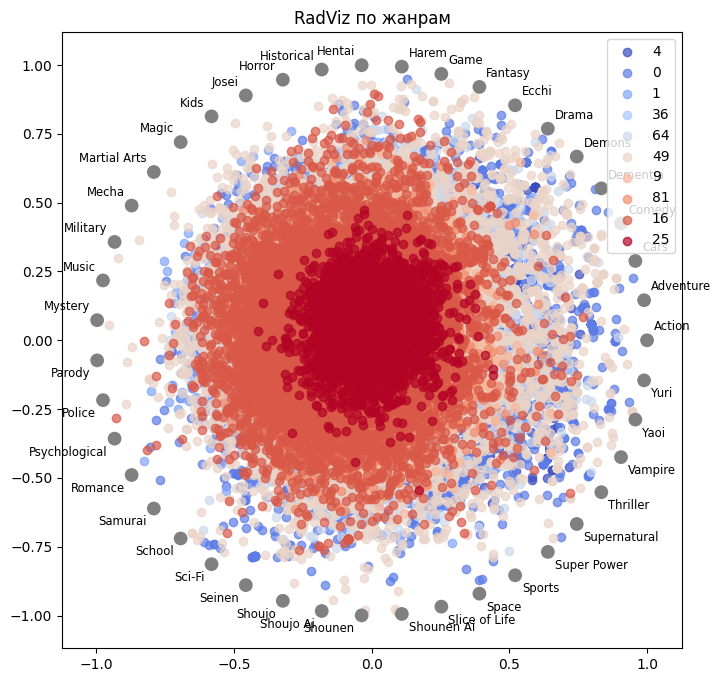

In [24]:
from pandas.plotting import radviz
cluster_centers = kmeans.cluster_centers_


plt.figure(figsize=(8, 8))
radviz(scaled_user_genre_ratings_df**2, 'cluster', colormap='coolwarm', alpha=0.7)
plt.title('RadViz по жанрам')
plt.show()

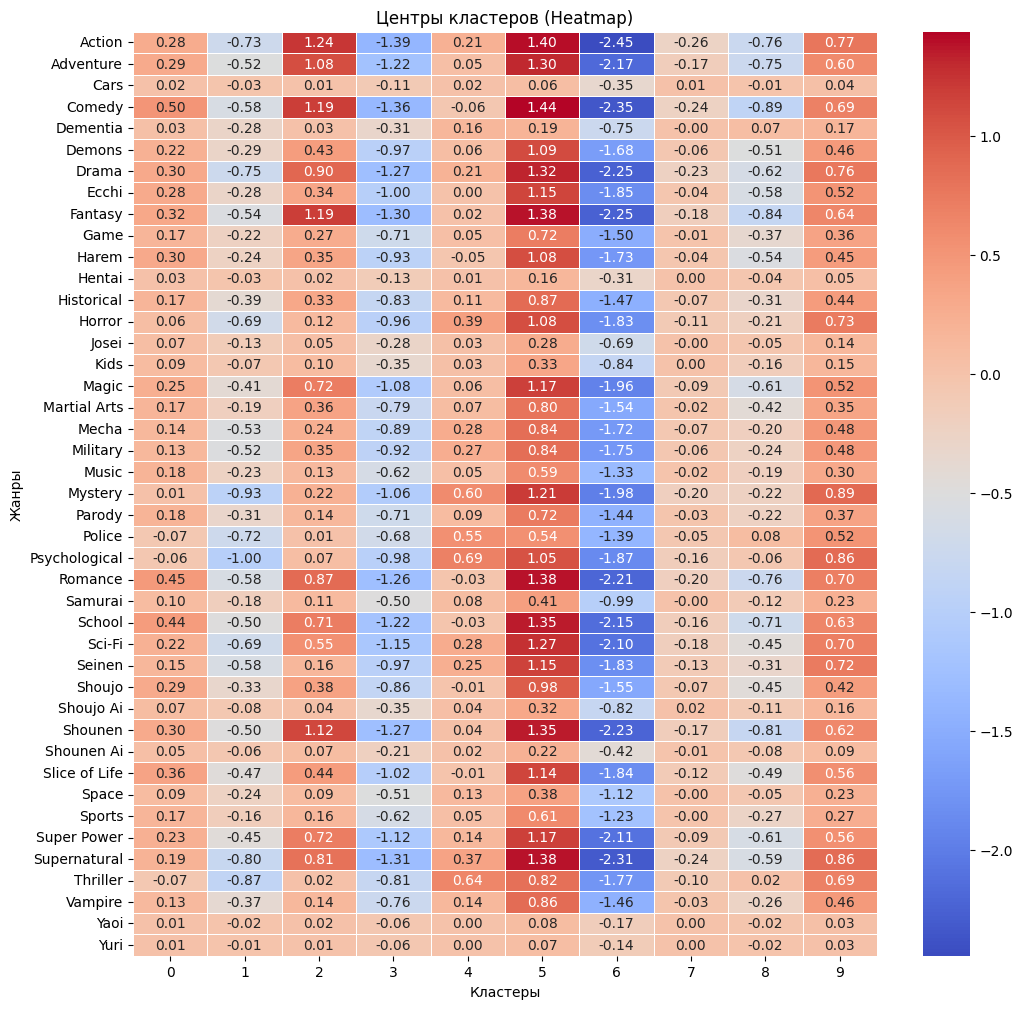

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Получаем центры кластеров из модели KMeans
cluster_centers = kmeans.cluster_centers_

# Создаем DataFrame с центрами кластеров
cluster_centers_df = pd.DataFrame(cluster_centers, columns=scaled_user_genre_ratings_df.columns[:-1])

# Строим тепловую карту
plt.figure(figsize=(12, 12))
plt.title('Центры кластеров (Heatmap)')
sns.heatmap(cluster_centers_df.T, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Кластеры')
plt.ylabel('Жанры')
plt.xticks(rotation=0)
plt.show()

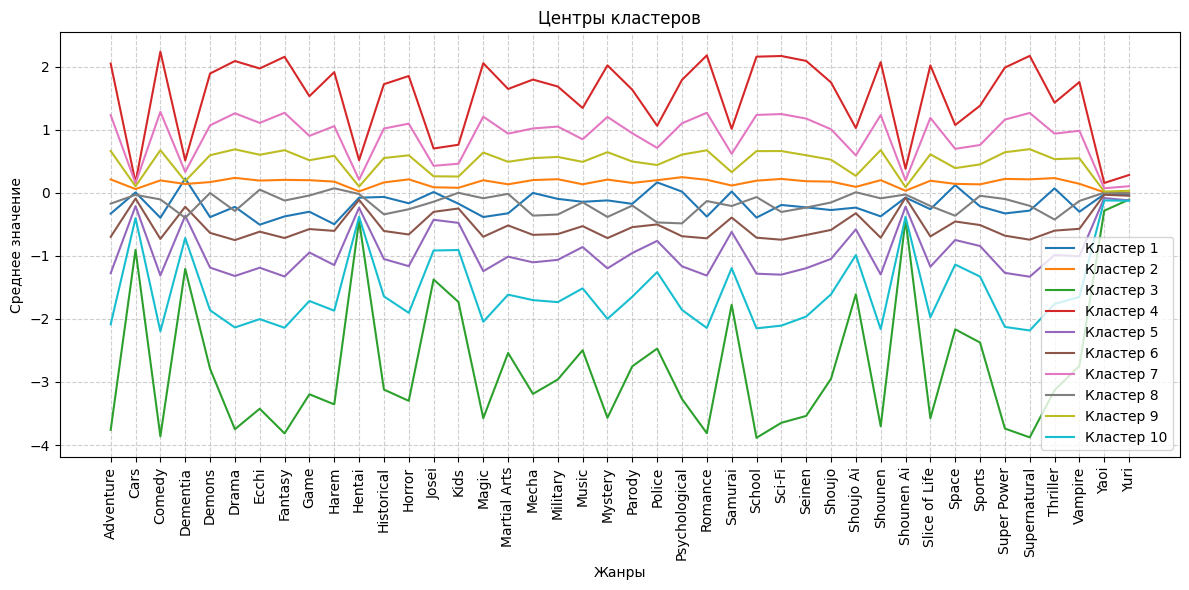

In [156]:
import matplotlib.pyplot as plt

# Получаем центры кластеров из модели KMeans
cluster_centers = kmeans.cluster_centers_

# Создаем DataFrame с центрами кластеров
cluster_centers_df = pd.DataFrame(cluster_centers, columns=scaled_user_genre_ratings_df.columns[:-1])

# Постройте график с центрами кластеров
plt.figure(figsize=(12, 6))
plt.title('Центры кластеров')
plt.xlabel('Жанры')
plt.ylabel('Среднее значение')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)

# Постройте бар-график для каждого кластера
for i, cluster_center in enumerate(cluster_centers_df.iterrows()):
    plt.plot(cluster_center[1], label=f'Кластер {i+1}')

plt.legend()
plt.tight_layout()
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

  0%|          | 0/29 [00:00<?, ?it/s]C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 10%|█         | 3/29 [00:00<00:01, 24.21it/s]C:\Users\Evgenie\AppData\Roa

Text(0, 0.5, '$J(C_k)$')

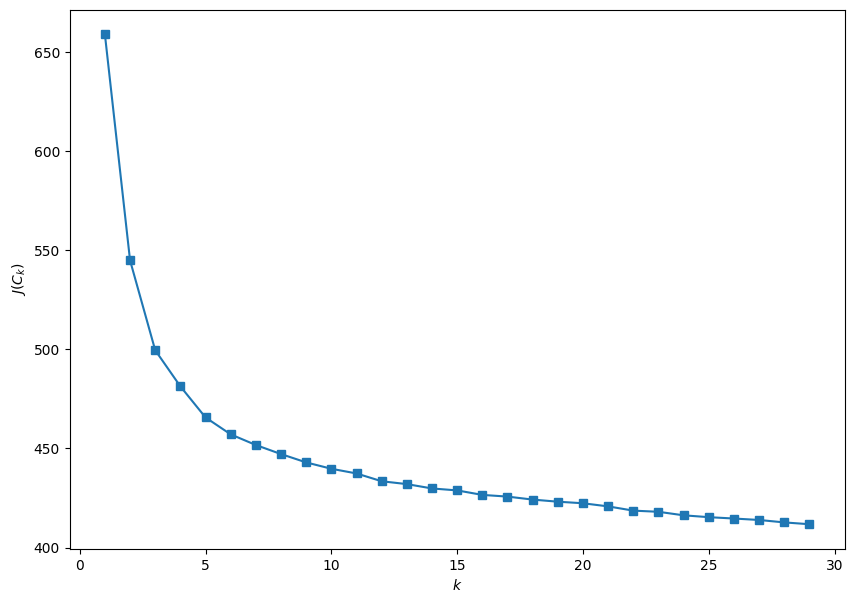

In [195]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(scaled_user_genre_ratings_df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [196]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

  0%|          | 0/28 [00:00<?, ?it/s]C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  4%|▎         | 1/28 [00:00<00:22,  1.18it/s]C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  7%|▋         | 2/28 [00:01<00:22,  1.17it/s]C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, d

2

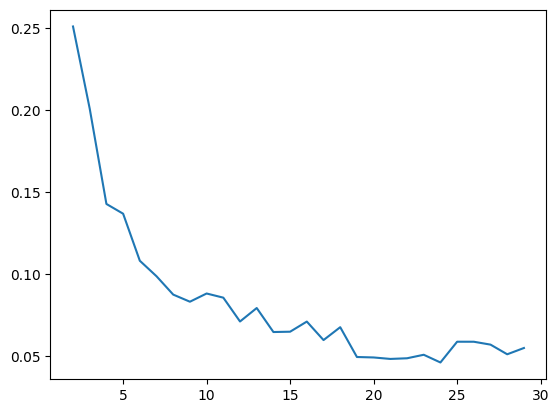

In [197]:
draw_sil_score(scaler.fit_transform(scaled_user_genre_ratings_df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

In [32]:
from sklearn.cluster import KMeans

# Создаем объект KMeans с 10 кластерами
kmeans = KMeans(n_clusters=3, random_state=0)

scaled_user_genre_ratings_df.fillna(0, inplace=True)

# Производим кластеризацию данных
clusters = kmeans.fit_predict(scaled_user_genre_ratings_df)

# Добавляем столбец 'cluster' в DataFrame с кластерами
scaled_user_genre_ratings_df['cluster'] = clusters

C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


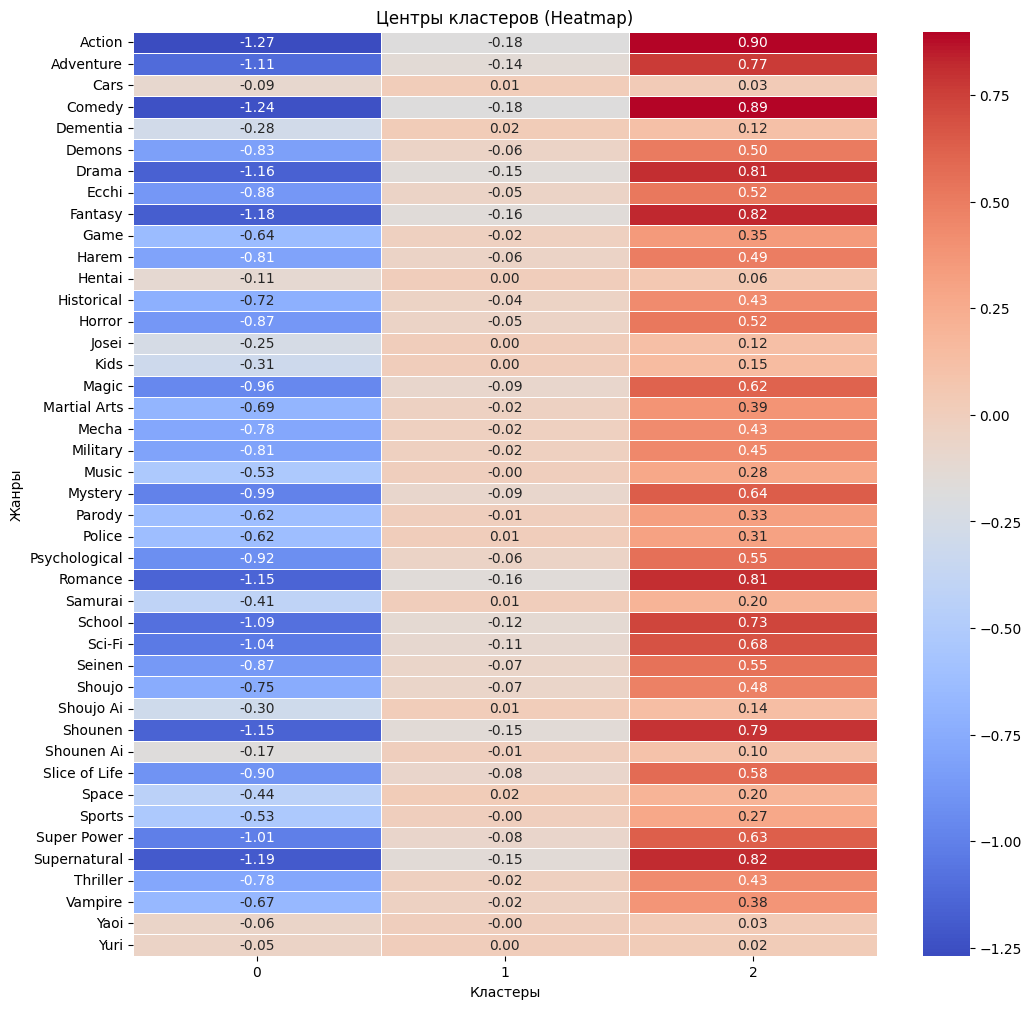

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Получаем центры кластеров из модели KMeans
cluster_centers = kmeans.cluster_centers_

# Создаем DataFrame с центрами кластеров без столбца 'cluster'
cluster_centers_df = pd.DataFrame(cluster_centers, columns=scaled_user_genre_ratings_df.columns[:-1])

# Строим тепловую карту
plt.figure(figsize=(12, 12))
plt.title('Центры кластеров (Heatmap)')
sns.heatmap(cluster_centers_df.T, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('Кластеры')
plt.ylabel('Жанры')
plt.xticks(rotation=0)
plt.show()

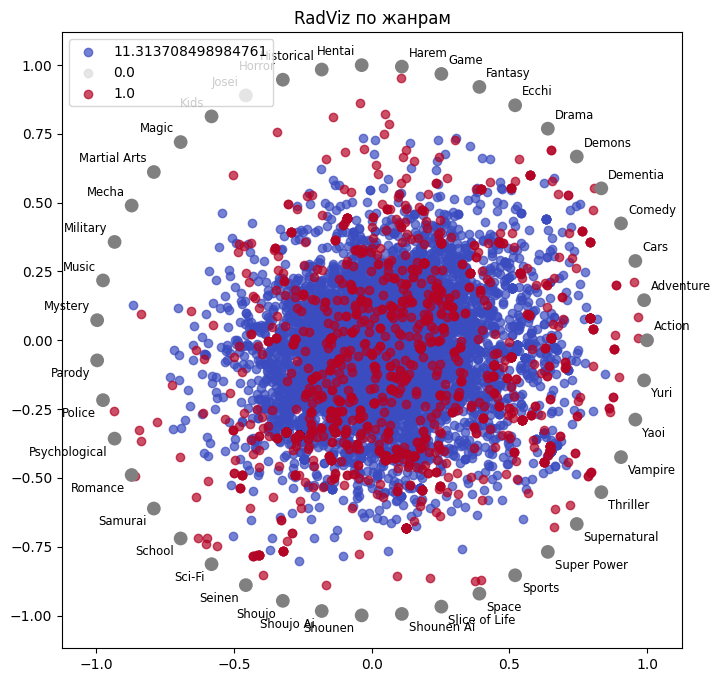

In [39]:
from pandas.plotting import radviz
cluster_centers = kmeans.cluster_centers_


plt.figure(figsize=(8, 8))
radviz(scaled_user_genre_ratings_df**3.5, 'cluster', colormap='coolwarm', alpha=0.7)
plt.title('RadViz по жанрам')
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю.
Это можно сделать разными способами. Как это сделать подумайте сами.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен.
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [42]:

sorted_genres_by_cluster = {}

for cluster in range(len(cluster_centers_df)):
    cluster_center = cluster_centers_df.iloc[cluster]  # Получите центр кластера
    sorted_genre_indices = cluster_center.argsort()[::-1]  # Индексы жанров в порядке убывания важности
    sorted_genres = cluster_centers_df.columns[sorted_genre_indices]  # Отсортированные жанры
    sorted_genres_by_cluster[cluster] = sorted_genres


sorted_genres_by_cluster

{0: Index(['Yuri', 'Yaoi', 'Cars', 'Hentai', 'Shounen Ai', 'Josei', 'Dementia',
        'Shoujo Ai', 'Kids', 'Samurai', 'Space', 'Sports', 'Music', 'Parody',
        'Police', 'Game', 'Vampire', 'Martial Arts', 'Historical', 'Shoujo',
        'Thriller', 'Mecha', 'Military', 'Harem', 'Demons', 'Seinen', 'Horror',
        'Ecchi', 'Slice of Life', 'Psychological', 'Magic', 'Mystery',
        'Super Power', 'Sci-Fi', 'School', 'Adventure', 'Romance', 'Shounen',
        'Drama', 'Fantasy', 'Supernatural', 'Comedy', 'Action'],
       dtype='object'),
 1: Index(['Dementia', 'Space', 'Shoujo Ai', 'Cars', 'Samurai', 'Police', 'Kids',
        'Hentai', 'Josei', 'Yuri', 'Yaoi', 'Sports', 'Music', 'Shounen Ai',
        'Parody', 'Game', 'Military', 'Mecha', 'Thriller', 'Vampire',
        'Martial Arts', 'Historical', 'Ecchi', 'Horror', 'Harem',
        'Psychological', 'Demons', 'Shoujo', 'Seinen', 'Super Power',
        'Slice of Life', 'Magic', 'Mystery', 'Sci-Fi', 'School', 'Adventure',
     